In [1]:
from matplotlib import pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets.cifar import CIFAR10

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc


def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.
    val_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=1) == labels).sum().item()
        val_loss /= len(dataloader)
        val_acc /= len(dataloader.dataset)
    return val_loss, val_acc


def train_model(model, train_dataloader, val_dataloader, optimizer, n_epochs, device=device):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        val_loss, val_acc = validate_epoch(model, val_dataloader, loss_fn, device)
        history['val_loss'].append(val_loss), history['val_acc'].append(val_acc)
        pbar.set_description(f'Training Accuracy {100 * train_acc:.2f}% | Validation Accuracy {100 * val_acc:.2f}% ')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='train')
    ax1.plot(history['val_loss'], label='val')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train')
    ax2.plot(history['val_acc'], label='val')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [3]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


In [4]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, image_size, patch_size, num_channels, hidden_size):
        super().__init__()
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (image_size // patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [5]:
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, image_size, patch_size, num_channels, hidden_size, hidden_dropout_prob):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(image_size, patch_size, num_channels, hidden_size)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of
        # the input sequence and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, hidden_size))
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [6]:
class ViT(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, image_size, patch_size, num_channels, hidden_size, num_heads, num_layers, mlp_dim, num_classes, dropout_rate=0.1):
        super().__init__()

        # Step 1: Embedding module (Patch + Position + CLS token)
        self.embeddings = Embeddings(image_size, patch_size, num_channels, hidden_size, dropout_rate)

        # Step 2: Transformer Encoder using PyTorch's built-in nn.TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,       # the number of expected features in the input
            nhead=num_heads,           # the number of heads in the multiheadattention models
            dim_feedforward=mlp_dim,   # the dimension of the feedforward network model
            dropout=dropout_rate,      # the dropout value
            activation='gelu',          # the activation function of the intermediate layer
            batch_first = True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Step 3: Classification head (MLP head)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # Step 1: Get patch + position embeddings and cls token
        x = self.embeddings(x)

        # Step 2: Pass through the transformer encoder
        x = self.encoder(x)

        # Step 3: Classification token is at position 0 of the sequence
        cls_token_output = x[:, 0]

        # Step 4: Pass through MLP classification head
        logits = self.mlp_head(cls_token_output)
        return logits

Training Accuracy 74.85% | Validation Accuracy 75.36% : 100%|██████████| 30/30 [13:49<00:00, 27.64s/it]


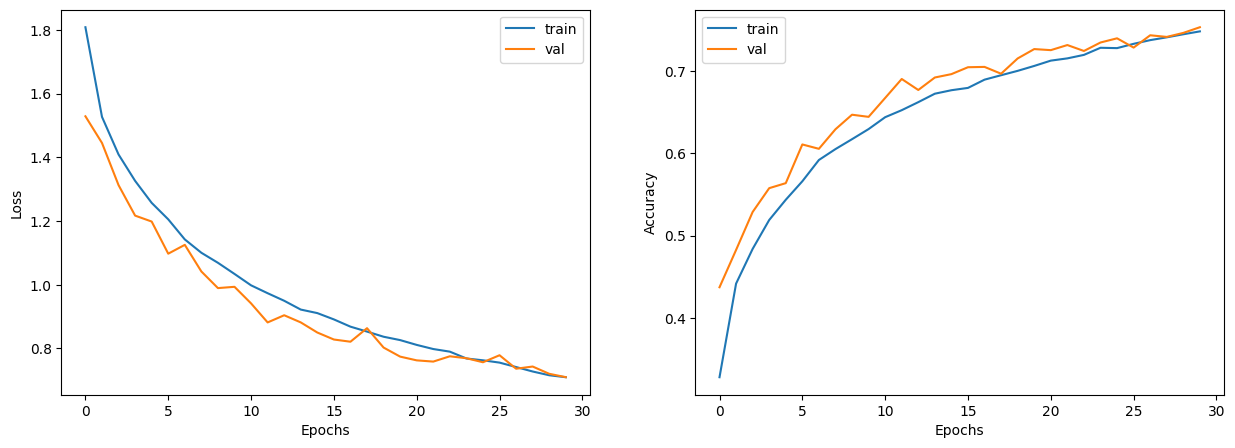

In [7]:
parameters = {
    'image_size': 32,
    'patch_size': 4,
    'num_channels': 3,
    'hidden_size': 128,
    'num_heads': 8,
    'num_layers': 6,
    'mlp_dim': 256,
    'num_classes': 10,
    'dropout_rate': 0.1,
}

vit = ViT(**parameters).to(device)
if device == 'cuda':
    vit = torch.compile(vit)
optim = Adam(vit.parameters(), lr=1e-3)

results = train_model(vit, trainloader, testloader, optim, n_epochs=30)
plot_history(results)